<a href="https://colab.research.google.com/github/adenurchalisa/Capstone-Model/blob/main/model_prediksi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# 1. Mount Google Drive (jika di Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/capstoneku/data_transaksi_advanced.csv'
df = pd.read_csv(file_path)
df['tanggal'] = pd.to_datetime(df['tanggal'])

In [4]:
# 2. Preprocessing Dasar
df = df.drop(columns=['rating', 'anomaly_flag', 'id_transaksi'])
df['bulan'] = df['tanggal'].dt.month
df['tahun'] = df['tanggal'].dt.year
df['jam'] = pd.to_datetime(df['waktu'], format='%H:%M').dt.hour
df = df.drop(columns=['tanggal', 'waktu'])

In [5]:
# 3. Fitur Musiman Sederhana
df['is_ramadan'] = (
    ((df['tahun'] == 2022) & (df['bulan'] == 4)) |
    ((df['tahun'] == 2023) & (df['bulan'].isin([3, 4]))) |
    ((df['tahun'] == 2024) & (df['bulan'].isin([3, 4])))
).astype(int)

df['is_lebaran'] = (
    ((df['tahun'] == 2022) & (df['bulan'] == 5)) |
    ((df['tahun'] == 2023) & (df['bulan'] == 4)) |
    ((df['tahun'] == 2024) & (df['bulan'] == 4))
).astype(int)

df['is_akhir_tahun'] = (df['bulan'] == 12).astype(int)

In [6]:
# 4. Filter data pengeluaran saja
df_pengeluaran = df[df['tipe'] == 'keluar'].copy()

In [7]:
# 5. Agregasi bulanan
agg = df_pengeluaran.groupby(['user_id', 'tahun', 'bulan']).agg(
    total_pengeluaran=('nominal', 'sum'),
    jumlah_transaksi=('nominal', 'count')
).reset_index()
agg = agg.sort_values(['user_id', 'tahun', 'bulan'])

In [8]:
# 6. Time-series features (sederhana)
agg['pengeluaran_bulan_lalu'] = agg.groupby('user_id')['total_pengeluaran'].shift(1)
agg['rolling3_pengeluaran'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).mean().shift(1).values
agg['target'] = agg.groupby('user_id')['total_pengeluaran'].shift(-1)

In [9]:
# 7. Tambahkan fitur musiman ke agregasi
agg['is_ramadan'] = (
    ((agg['tahun'] == 2022) & (agg['bulan'] == 4)) |
    ((agg['tahun'] == 2023) & (agg['bulan'].isin([3, 4]))) |
    ((agg['tahun'] == 2024) & (agg['bulan'].isin([3, 4])))
).astype(int)
agg['is_lebaran'] = (
    ((agg['tahun'] == 2022) & (agg['bulan'] == 5)) |
    ((agg['tahun'] == 2023) & (agg['bulan'] == 4)) |
    ((agg['tahun'] == 2024) & (agg['bulan'] == 4))
).astype(int)
agg['is_akhir_tahun'] = (agg['bulan'] == 12).astype(int)

In [10]:
# 8. Drop NA baris
agg = agg.dropna(subset=['target', 'pengeluaran_bulan_lalu']).reset_index(drop=True)

In [11]:
# 9. Split data
train = agg[agg['tahun'] < 2024]
test = agg[agg['tahun'] == 2024]

In [12]:
# 10. Fitur yang benar-benar penting saja
fitur_sederhana = [
    'pengeluaran_bulan_lalu',
    'rolling3_pengeluaran',
    'bulan',
    'is_ramadan',
    'is_lebaran',
    'is_akhir_tahun'
]
X_train = train[fitur_sederhana]
y_train = train['target']
X_test = test[fitur_sederhana]
y_test = test['target']

In [13]:
# 11. Log transform target (untuk stabilitas)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [14]:
# 12. BASELINE MODEL: Pengeluaran bulan lalu
print("\n===== BASELINE MODEL =====")
baseline_pred = X_test['pengeluaran_bulan_lalu'].values
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_mape = np.mean(np.abs((y_test - baseline_pred) / y_test)) * 100
print(f"Baseline MAE: {baseline_mae:.2f}")
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Baseline MAPE: {baseline_mape:.2f}%")


===== BASELINE MODEL =====
Baseline MAE: 8093284.09
Baseline RMSE: 11938439.10
Baseline MAPE: 674.36%


In [15]:
# 13. MODEL SEDERHANA DENGAN XGBOOST
print("\n===== MODEL SEDERHANA =====")
model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train, y_train_log)


===== MODEL SEDERHANA =====


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
# 14. Evaluasi model
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Model MAE: {mae:.2f}")
print(f"Model RMSE: {rmse:.2f}")
print(f"Model MAPE: {mape:.2f}%")

Model MAE: 6868809.13
Model RMSE: 10591207.68
Model MAPE: 531.16%


In [17]:
# 15. Feature importance
importance = pd.DataFrame({
    'feature': fitur_sederhana,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(importance)


Feature Importance:
                  feature  importance
1    rolling3_pengeluaran    0.345229
2                   bulan    0.214403
0  pengeluaran_bulan_lalu    0.192768
3              is_ramadan    0.135455
4              is_lebaran    0.112144
5          is_akhir_tahun    0.000000


In [19]:
# 16. Analisis error per user
print("\n===== ANALISIS ERROR PER USER =====")
df_error = pd.DataFrame({
    'user_id': test['user_id'],
    'bulan': test['bulan'],
    'tahun': test['tahun'],
    'actual': y_test.values,
    'pred': y_pred,
    'error': np.abs(y_test.values - y_pred),
    'mape': 100 * np.abs(y_test.values - y_pred) / y_test.values
})


===== ANALISIS ERROR PER USER =====


In [20]:
# 17. Identifikasi user dengan error tinggi dan rendah
user_error = df_error.groupby('user_id')['mape'].mean().sort_values()
low_error_users = user_error[user_error <= 50].index.tolist()
high_error_users = user_error[user_error > 200].index.tolist()

print(f"User dengan prediksi bagus (MAPE ≤ 50%): {len(low_error_users)} users")
print(f"User dengan prediksi sangat buruk (MAPE > 200%): {len(high_error_users)} users")

User dengan prediksi bagus (MAPE ≤ 50%): 6 users
User dengan prediksi sangat buruk (MAPE > 200%): 9 users


In [21]:
# 18. Persentil distribusi error
error_percentiles = np.percentile(df_error['mape'], [25, 50, 75, 90])
print(f"\nDistribusi Error MAPE:")
print(f"25% data memiliki MAPE ≤ {error_percentiles[0]:.1f}%")
print(f"50% data memiliki MAPE ≤ {error_percentiles[1]:.1f}%")
print(f"75% data memiliki MAPE ≤ {error_percentiles[2]:.1f}%")
print(f"90% data memiliki MAPE ≤ {error_percentiles[3]:.1f}%")


Distribusi Error MAPE:
25% data memiliki MAPE ≤ 39.5%
50% data memiliki MAPE ≤ 62.9%
75% data memiliki MAPE ≤ 107.4%
90% data memiliki MAPE ≤ 803.2%


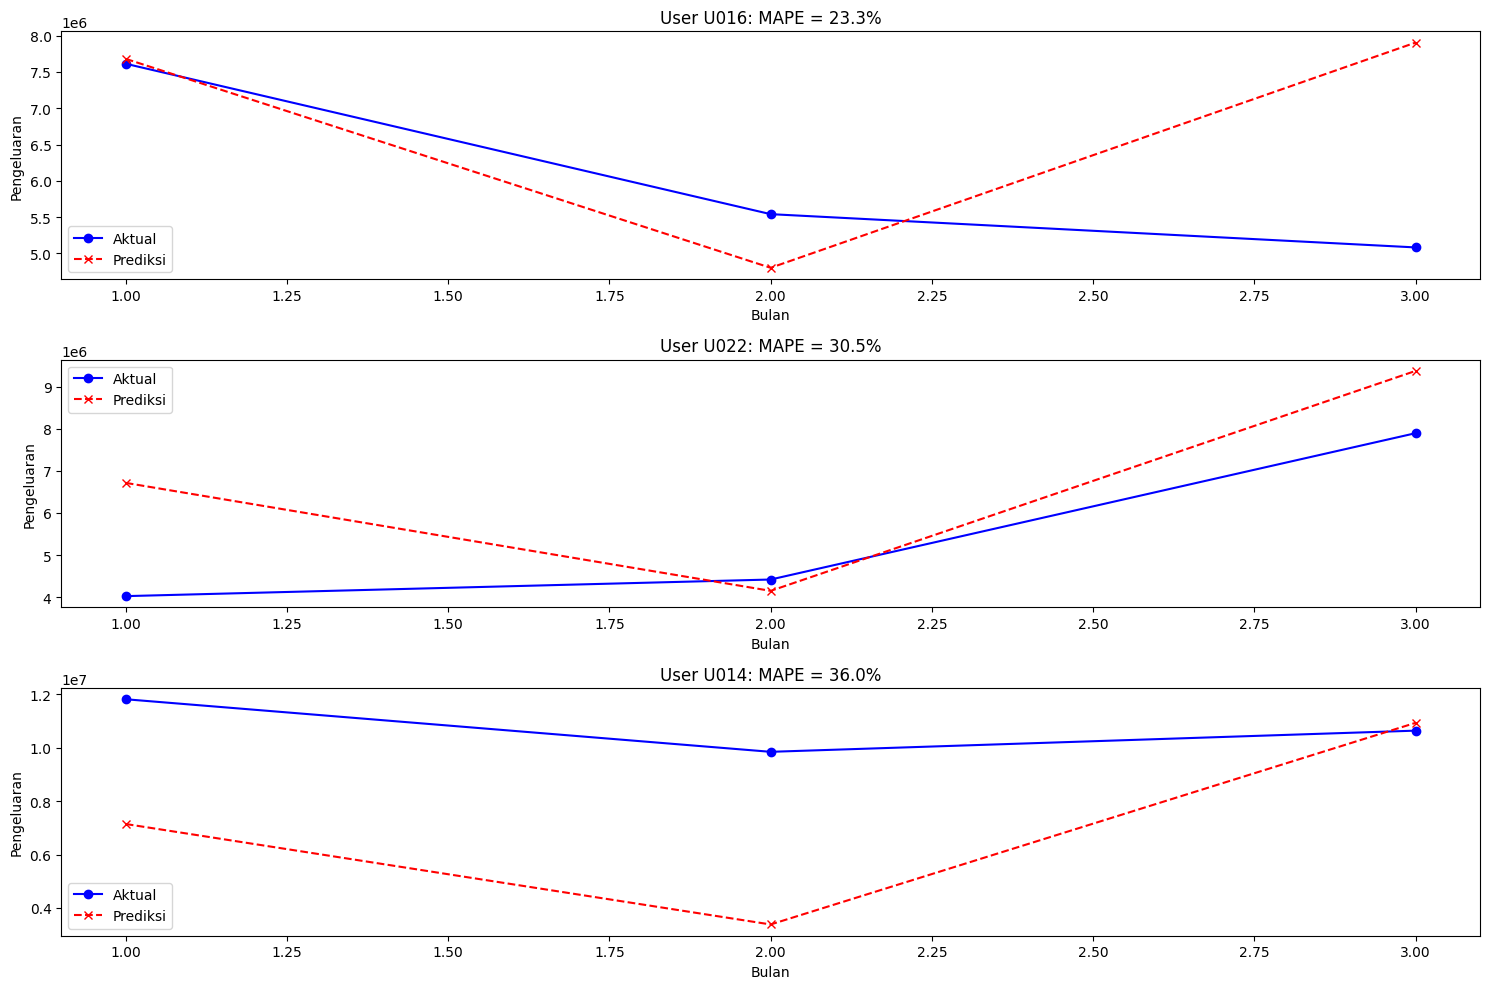

In [22]:
# 19. Visualisasi prediksi vs aktual untuk 3 user dengan error rendah
try:
    plt.figure(figsize=(15, 10))
    for i, user in enumerate(low_error_users[:3]):
        user_data = df_error[df_error['user_id'] == user]
        plt.subplot(3, 1, i+1)
        plt.plot(user_data['bulan'], user_data['actual'], 'b-o', label='Aktual')
        plt.plot(user_data['bulan'], user_data['pred'], 'r--x', label='Prediksi')
        plt.title(f'User {user}: MAPE = {user_error[user]:.1f}%')
        plt.xlabel('Bulan')
        plt.ylabel('Pengeluaran')
        plt.legend()
    plt.tight_layout()
    plt.savefig('prediksi_user_bagus.png')
    plt.show()
except:
    print("Tidak bisa menampilkan visualisasi.")

In [23]:
# 20. MODEL HIBRID: Kombinasi model dan baseline (untuk mengurangi error)
print("\n===== MODEL HIBRID =====")
df_error['hibrid_pred'] = 0.7 * y_pred + 0.3 * baseline_pred  # 70% model, 30% baseline
hibrid_mae = mean_absolute_error(y_test, df_error['hibrid_pred'])
hibrid_mape = np.mean(np.abs((y_test - df_error['hibrid_pred']) / y_test)) * 100
print(f"Hibrid MAE: {hibrid_mae:.2f}")
print(f"Hibrid MAPE: {hibrid_mape:.2f}%")


===== MODEL HIBRID =====
Hibrid MAE: 6606250.79
Hibrid MAPE: 564.82%


In [24]:
# 21. PREDIKSI BULAN BERIKUTNYA
print("\n===== PREDIKSI BULAN BERIKUTNYA =====")

# Ambil data bulan terakhir untuk tiap user
latest_data = test.sort_values(['user_id', 'tahun', 'bulan']).groupby('user_id').last().reset_index()

# Siapkan data untuk bulan berikutnya
next_month_data = []
for _, row in latest_data.iterrows():
    user_id = row['user_id']
    current_month = row['bulan']
    current_year = row['tahun']

    # Tentukan bulan & tahun berikutnya
    next_month = current_month % 12 + 1
    next_year = current_year + 1 if next_month == 1 else current_year

    # Cek fitur musiman
    is_ramadan = 1 if (next_year == 2024 and next_month in [3, 4]) else 0
    is_lebaran = 1 if (next_year == 2024 and next_month == 4) else 0
    is_akhir_tahun = 1 if next_month == 12 else 0

    # Buat data input
    next_data = {
        'user_id': user_id,
        'bulan': next_month,
        'tahun': next_year,
        'pengeluaran_bulan_lalu': row['total_pengeluaran'],
        'rolling3_pengeluaran': row['rolling3_pengeluaran'],
        'is_ramadan': is_ramadan,
        'is_lebaran': is_lebaran,
        'is_akhir_tahun': is_akhir_tahun
    }
    next_month_data.append(next_data)

# Buat DataFrame untuk prediksi
X_next = pd.DataFrame(next_month_data)

# Prediksi dengan model dan baseline
X_next_features = X_next[fitur_sederhana]
y_next_log = model.predict(X_next_features)
y_next = np.expm1(y_next_log)

# Hasil prediksi
results = pd.DataFrame({
    'user_id': X_next['user_id'],
    'tahun': X_next['tahun'],
    'bulan': X_next['bulan'],
    'prediksi_pengeluaran': y_next,
    'pengeluaran_bulan_lalu': X_next['pengeluaran_bulan_lalu']
})

# Untuk user dengan error tinggi, gunakan rata-rata antara prediksi dan bulan lalu
results['prediksi_final'] = results['prediksi_pengeluaran']
for user in high_error_users:
    if user in results['user_id'].values:
        mask = results['user_id'] == user
        results.loc[mask, 'prediksi_final'] = 0.5 * results.loc[mask, 'prediksi_pengeluaran'] + \
                                             0.5 * results.loc[mask, 'pengeluaran_bulan_lalu']

print("\nPrediksi untuk beberapa user (bulan berikutnya):")
print(results[['user_id', 'bulan', 'tahun', 'prediksi_final']].head(10))


===== PREDIKSI BULAN BERIKUTNYA =====

Prediksi untuk beberapa user (bulan berikutnya):
  user_id  bulan  tahun  prediksi_final
0    U001      4   2024    3.227805e+06
1    U002      4   2024    2.320738e+06
2    U003      4   2024    5.269732e+06
3    U004      5   2024    1.624820e+07
4    U005      4   2024    5.713001e+06
5    U006      5   2024    6.022564e+06
6    U007      5   2024    1.677599e+07
7    U008      4   2024    8.152198e+06
8    U009      4   2024    1.474930e+07
9    U010      4   2024    8.307978e+06


<ipython-input-24-3321280846>:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6030072.352]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  results.loc[mask, 'prediksi_final'] = 0.5 * results.loc[mask, 'prediksi_pengeluaran'] + \


In [25]:
# 22. Simpan model dan prediksi
import joblib
# Simpan model
joblib.dump(model, 'model_xgb_pengeluaran.pkl')

# Simpan hasil prediksi
results.to_csv('prediksi_pengeluaran_bulanan.csv', index=False)
print("\nModel dan hasil prediksi telah disimpan!")


Model dan hasil prediksi telah disimpan!


In [26]:
# 23. Cara load model untuk penggunaan di masa depan
print("\n===== CONTOH KODE UNTUK MENGGUNAKAN MODEL DI MASA DEPAN =====")
print('''
# Load model
import joblib
model = joblib.load('model_xgb_pengeluaran.pkl')

# Siapkan data untuk user baru
X_new = pd.DataFrame([{
    'pengeluaran_bulan_lalu': 2000000,  # pengeluaran bulan ini
    'rolling3_pengeluaran': 1800000,    # rata-rata 3 bulan terakhir
    'bulan': 7,                         # bulan yang diprediksi
    'is_ramadan': 0,                    # sesuaikan dengan kalender
    'is_lebaran': 0,                    # sesuaikan dengan kalender
    'is_akhir_tahun': 0                 # 1 jika bulan 12
}])

# Prediksi
y_pred_log = model.predict(X_new)
y_pred = np.expm1(y_pred_log)
print(f"Prediksi pengeluaran: Rp {y_pred[0]:,.2f}")
''')

print("\nKode selesai dijalankan!")


===== CONTOH KODE UNTUK MENGGUNAKAN MODEL DI MASA DEPAN =====

# Load model
import joblib
model = joblib.load('model_xgb_pengeluaran.pkl')

# Siapkan data untuk user baru
X_new = pd.DataFrame([{
    'pengeluaran_bulan_lalu': 2000000,  # pengeluaran bulan ini
    'rolling3_pengeluaran': 1800000,    # rata-rata 3 bulan terakhir
    'bulan': 7,                         # bulan yang diprediksi
    'is_ramadan': 0,                    # sesuaikan dengan kalender
    'is_lebaran': 0,                    # sesuaikan dengan kalender
    'is_akhir_tahun': 0                 # 1 jika bulan 12
}])

# Prediksi
y_pred_log = model.predict(X_new)
y_pred = np.expm1(y_pred_log)
print(f"Prediksi pengeluaran: Rp {y_pred[0]:,.2f}")


Kode selesai dijalankan!
